In [1]:
import matplotlib
matplotlib.use('Agg')

import sys
sys.settrace
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from pylab import *
import struct
import array
import os
from scipy.interpolate import griddata

import h5py

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["DejaVu Serif"]})

plt.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']
plt.rcParams['font.size'] = '20'

/var/folders/2n/ftypqy6s65s2j7krblnn49cw0000gq/T/ipykernel_30757/3131495678.py:22: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  plt.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']


In [2]:
import athena_read

In [3]:
vol_func = lambda rm,rp,thetam,thetap,phim,phip: \
            1.0/3.0*(rp**3-rm**3) * abs(np.cos(thetam)-np.cos(thetap)) * (phip-phim)
rarea_func = lambda r,thetam,thetap, phim, phip: \
           r**2.0 * abs(np.cos(thetam)-np.cos(thetap)) * (phip-phim)
tarea_func = lambda rm, rp, theta, phim, phip: \
          0.5*(rp**2.0 - rm**2.0)*np.sin(theta)*(phip - phim)
parea_func = lambda rm, rp, thetam, thetap: \
          0.5*(rp**2.0 - rm**2.0)*abs(thetap - thetam)

In [55]:
def PlotProfile2(data,sol,filename,ylabel1,ylabel2,label1=None,label2=None):
    plots, axes = plt.subplots(2,1,figsize=(9,11),dpi=300,sharex=True)
    plt.subplots_adjust(left=0.17,right=0.95,top=0.95,bottom=0.1,hspace=0.02)
    plt.xlabel('$ r $', size = 30)
    plt.xlim([0.4,10])
    
    nu_weight=sol[4]

    axes[0].plot(data[0],data[4][0,:],linewidth=4.0,color='blue',alpha=0.5,label=label1)
    axes[0].plot(data[0],data[4][1,:],linewidth=4.0,color='green',alpha=0.5,label='$E_{r,1}$')
    axes[0].plot(data[0],data[4][2,:],linewidth=4.0,color='orange',alpha=0.5,label='$E_{r,2}$')
    axes[0].plot(data[0],data[3]/data[1],linewidth=4.0,color='red',alpha=0.5,label=label2)
    axes[0].plot(sol[0],sol[1]*nu_weight[0],linewidth=2.0,color='black',linestyle='dashed')
    axes[0].plot(sol[0],sol[1]*nu_weight[1],linewidth=2.0,color='black',linestyle='dashed')
    axes[0].plot(sol[0],sol[1]*nu_weight[2],linewidth=2.0,color='black',linestyle='dashed')
    axes[0].plot(sol[0],sol[3]/sol[1],linewidth=2.0,color='black',linestyle='dashed')
#    axes[0].set_xscale('log')
    axes[0].set_ylabel(ylabel1, size=30)
    axes[0].set_ylim(2.e-5,1.5)  
    axes[0].set_yscale('log')  
    axes[0].yaxis.set_tick_params(labelsize=25)

    if label1 is not None:
        axes[0].legend(loc=[0.01,0.001],frameon=False,fontsize = 22)

#    axes[0].text(1.e-2, 2.3, '$a_rT_0^4/P_0=0.01$', dict(size=25,color='black'))
#    axes[0].text(1.e-2, 2.1, '$a_rT_0^4/P_0=1$', dict(size=25,color='blue'))
#    axes[0].text(1.e-2, 1.9, '$a_rT_0^4/P_0=10$', dict(size=25,color='red'))    


    axes[1].plot(data[0],data[5][0,:],linewidth=4.0,color='blue',alpha=0.5,label='$F_{r,0}$')
    axes[1].plot(data[0],data[5][1,:],linewidth=4.0,color='green',alpha=0.5,label='$F_{r,1}$')
    axes[1].plot(data[0],data[5][2,:],linewidth=4.0,color='orange',alpha=0.5,label='$F_{r,2}$')    
    axes[1].plot(sol[0],sol[2]*nu_weight[0],linewidth=2.0,color='black',linestyle='dashed')    
    axes[1].plot(sol[0],sol[2]*nu_weight[1],linewidth=2.0,color='black',linestyle='dashed')  
    axes[1].plot(sol[0],sol[2]*nu_weight[2],linewidth=2.0,color='black',linestyle='dashed')  
    
    axes[1].set_yscale('log')
    axes[1].set_xscale('log')
    axes[1].set_ylabel(ylabel2, size=30)
    axes[1].set_ylim(1.e-6,0.7)    
    axes[1].yaxis.set_tick_params(labelsize=25)
    axes[1].xaxis.set_tick_params(labelsize=25)
    axes[1].legend(loc=[0.3,0.001],frameon=False,fontsize = 22)


    plt.savefig(filename)
    plt.clf()


In [5]:
gamma=5.0/3.0
file1='Data/hsphere.out1.00100.athdf'

with h5py.File(file1, 'r') as f:
  attributes = f.attrs.items()
  attrs = dict(attributes)
  level = f.attrs['MaxLevel']
  time1 = f.attrs['Time']
  subsample = False

  data1 = athena_read.athdf(file1,level=level, subsample=subsample)


In [6]:
nx1 = attrs['RootGridSize'][0] * 2**level
nx2 = attrs['RootGridSize'][1] * 2**level
nx3 = attrs['RootGridSize'][2] * 2**level
x1f = data1['x1f']
x2f = data1['x2f']
x3f = data1['x3f']
x1v = data1['x1v'] 
x2v = data1['x2v']
x3v = data1['x3v']
vol = np.zeros((nx3,nx2,nx1))


In [7]:
print(data1['VariableNames'])

[b'rho' b'press' b'vel1' b'vel2' b'vel3' b'Er_0' b'Fr_0_1' b'Fr_0_2'
 b'Fr_0_3' b'Pr_0_11' b'Pr_0_22' b'Pr_0_33' b'Pr_0_12' b'Pr_0_13'
 b'Pr_0_23' b'Pr_0_21' b'Pr_0_31' b'Pr_0_32' b'Er0_0' b'Fr0_0_1'
 b'Fr0_0_2' b'Fr0_0_3' b'Er_1' b'Fr_1_1' b'Fr_1_2' b'Fr_1_3' b'Pr_1_11'
 b'Pr_1_22' b'Pr_1_33' b'Pr_1_12' b'Pr_1_13' b'Pr_1_23' b'Pr_1_21'
 b'Pr_1_31' b'Pr_1_32' b'Er0_1' b'Fr0_1_1' b'Fr0_1_2' b'Fr0_1_3' b'Er_2'
 b'Fr_2_1' b'Fr_2_2' b'Fr_2_3' b'Pr_2_11' b'Pr_2_22' b'Pr_2_33' b'Pr_2_12'
 b'Pr_2_13' b'Pr_2_23' b'Pr_2_21' b'Pr_2_31' b'Pr_2_32' b'Er0_2'
 b'Fr0_2_1' b'Fr0_2_2' b'Fr0_2_3' b'Sigma_s_0' b'Sigma_a_0' b'Sigma_p_0'
 b'Sigma_s_1' b'Sigma_a_1' b'Sigma_p_1' b'Sigma_s_2' b'Sigma_a_2'
 b'Sigma_p_2']


In [8]:
for k in range(nx3):
    for j in range(nx2):
        for i in range(nx1):
            vol[k,j,i]=vol_func(x1f[i],x1f[i+1],x2f[j],x2f[j+1],x3f[k],x3f[k+1])

In [9]:
#for filename in files:
ang_file = open('Data/Rad_angles.txt', 'r')
Lines = ang_file.readlines()
angle_line = [ line for line in Lines if  "tau_scheme" in line]
angle_line=angle_line[0]

prat_line = [ line for line in Lines if  "Prat" in line]
prat_line=prat_line[0]
prat_split=prat_line.split(" ")
Prat=float(prat_split[size(prat_split)-2])


crat_line = [ line for line in Lines if  "Crat" in line]
crat_line=crat_line[0]
Crat_split=crat_line.split(" ")
Crat=float(Crat_split[size(Crat_split)-2])


angle_index=Lines.index(angle_line)+1
location=Lines.index('fre   spec\n')
tot_line=size(Lines)
nfreq=tot_line-location-1
nu_grid=np.zeros(nfreq)
nu_weight=np.zeros(nfreq)
for i in range(nfreq):
    line=Lines[i+location+1].split(' ')
    nu_grid[i]=float(line[0])
    nu_weight[i]=float(line[3])

nu_center=np.zeros(nfreq-1)
nu_center[:]=(nu_grid[:-1]+nu_grid[1:])/2

nu_plot=np.zeros(nfreq)
nu_plot[:-1]=nu_center
nu_plot[nfreq-1]=nu_grid[nfreq-1]

#nu_center=np.append(nu_center,nu_grid[nfreq-1])
nang=location-angle_index
mu_x=np.zeros(nang)
mu_y=np.zeros(nang)
mu_z=np.zeros(nang)
weight=np.zeros(nang)
for n in range(nang):
    line=Lines[n+angle_index].split('   ')
    mu_x[n]=float(line[1])
    mu_y[n]=float(line[2])
    mu_z[n]=float(line[3])
    weight[n]=float(line[4].rstrip())

In [10]:
rho1=data1['rho']
pg1=data1['press']
vx1=data1['vel1']
vy1=data1['vel2']
vz1=data1['vel3']


er_fr=np.zeros((nfreq,nx1))
pr_fr=np.zeros((nfreq,nx1))
fr_fr=np.zeros((nfreq,nx1))
er_profile=np.zeros(nx1)
fr_profile=np.zeros(nx1)
pr_profile=np.zeros(nx1)


In [11]:
for j in range(nfreq):
    varname='Er_'+str(j)
    er_fr[j,:]=data1[varname][0,0,:]
    varname='Fr_'+str(j)+'_1'
    fr_fr[j,:]=data1[varname][0,0,:]
    varname='Pr_'+str(j)+'_11'
    pr_fr[j,:]=data1[varname][0,0,:]
er_profile=np.sum(er_fr,axis=0)
fr_profile=np.sum(fr_fr,axis=0)
pr_profile=np.sum(pr_fr,axis=0)

In [12]:
dprdr=np.zeros((nfreq,nx1))
for j in range(nfreq):
    for i in range(1,nx1-1):
        dprdr[j,i]=(pr_fr[j,i+1]-pr_fr[j,i-1])/(x1v[i+1]-x1v[i-1])

In [13]:
##load the solution
sol_radius=np.loadtxt('Data/radius.txt')
sol_Er=np.loadtxt('Data/Er.txt')
sol_Fr=np.loadtxt('Data/Fr.txt')
sol_Pr=np.loadtxt('Data/Pr.txt')

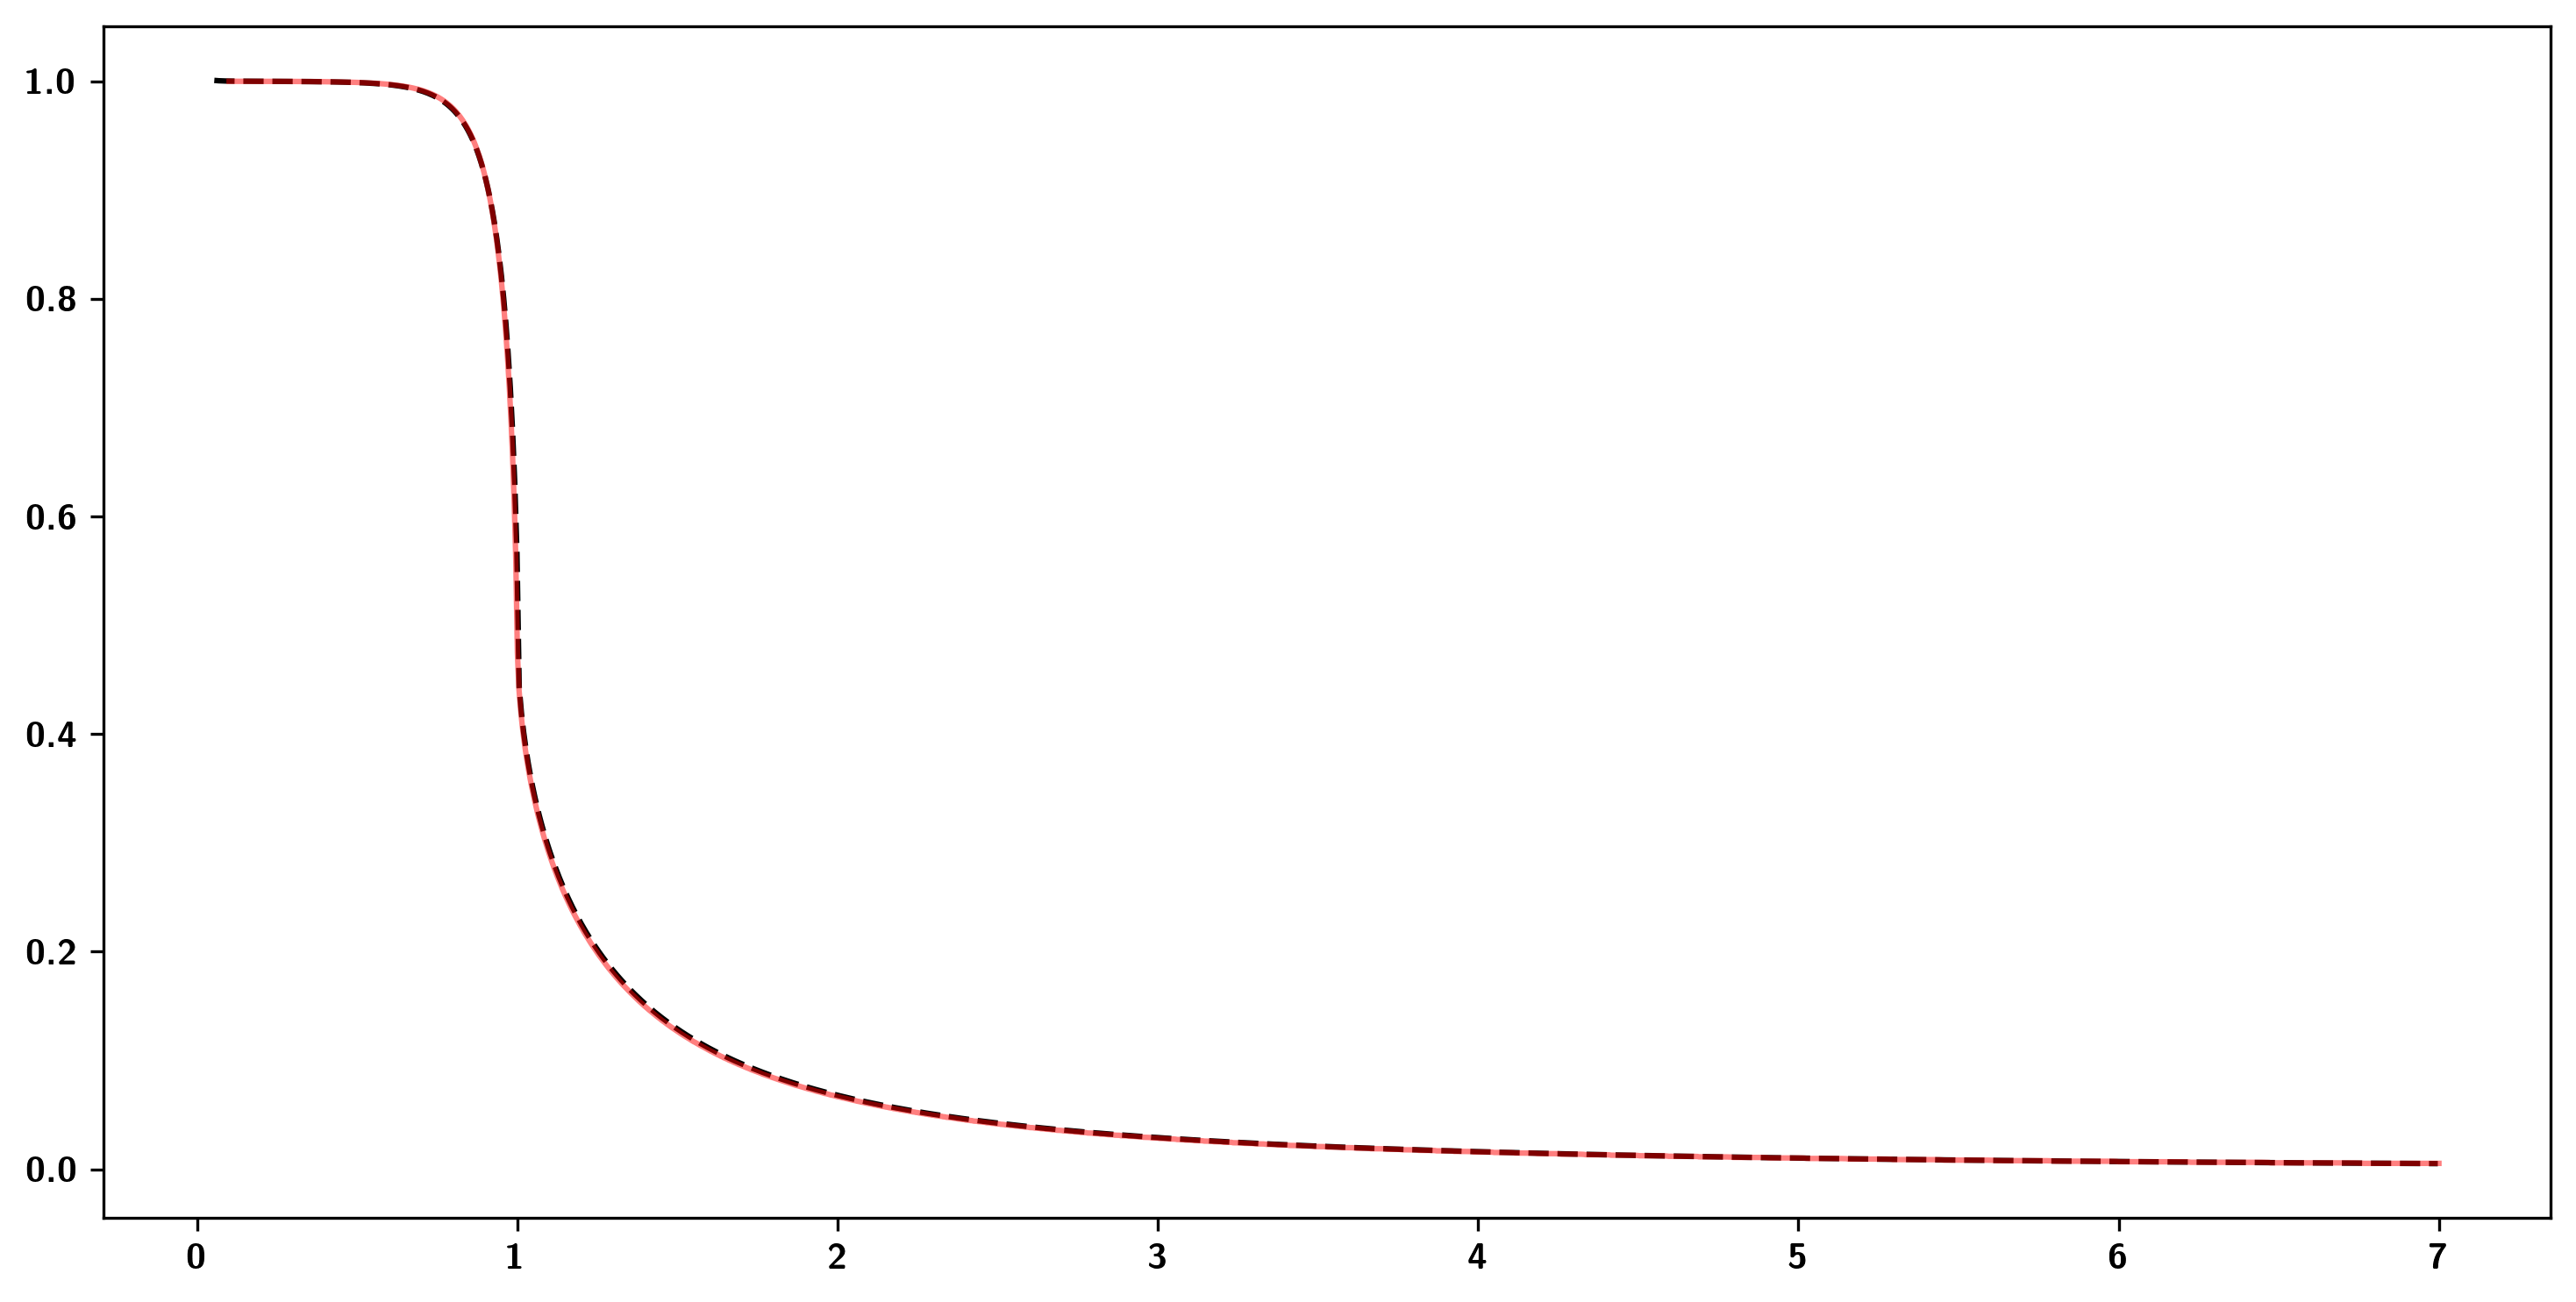

In [14]:
%matplotlib inline
plots, axes = plt.subplots(figsize=(12,6),dpi=300)
axes.plot(x1v,er_profile,color='black',linestyle='dashed')
axes.plot(sol_radius,sol_Er,color='red',alpha=0.5)

In [15]:
plt.show()

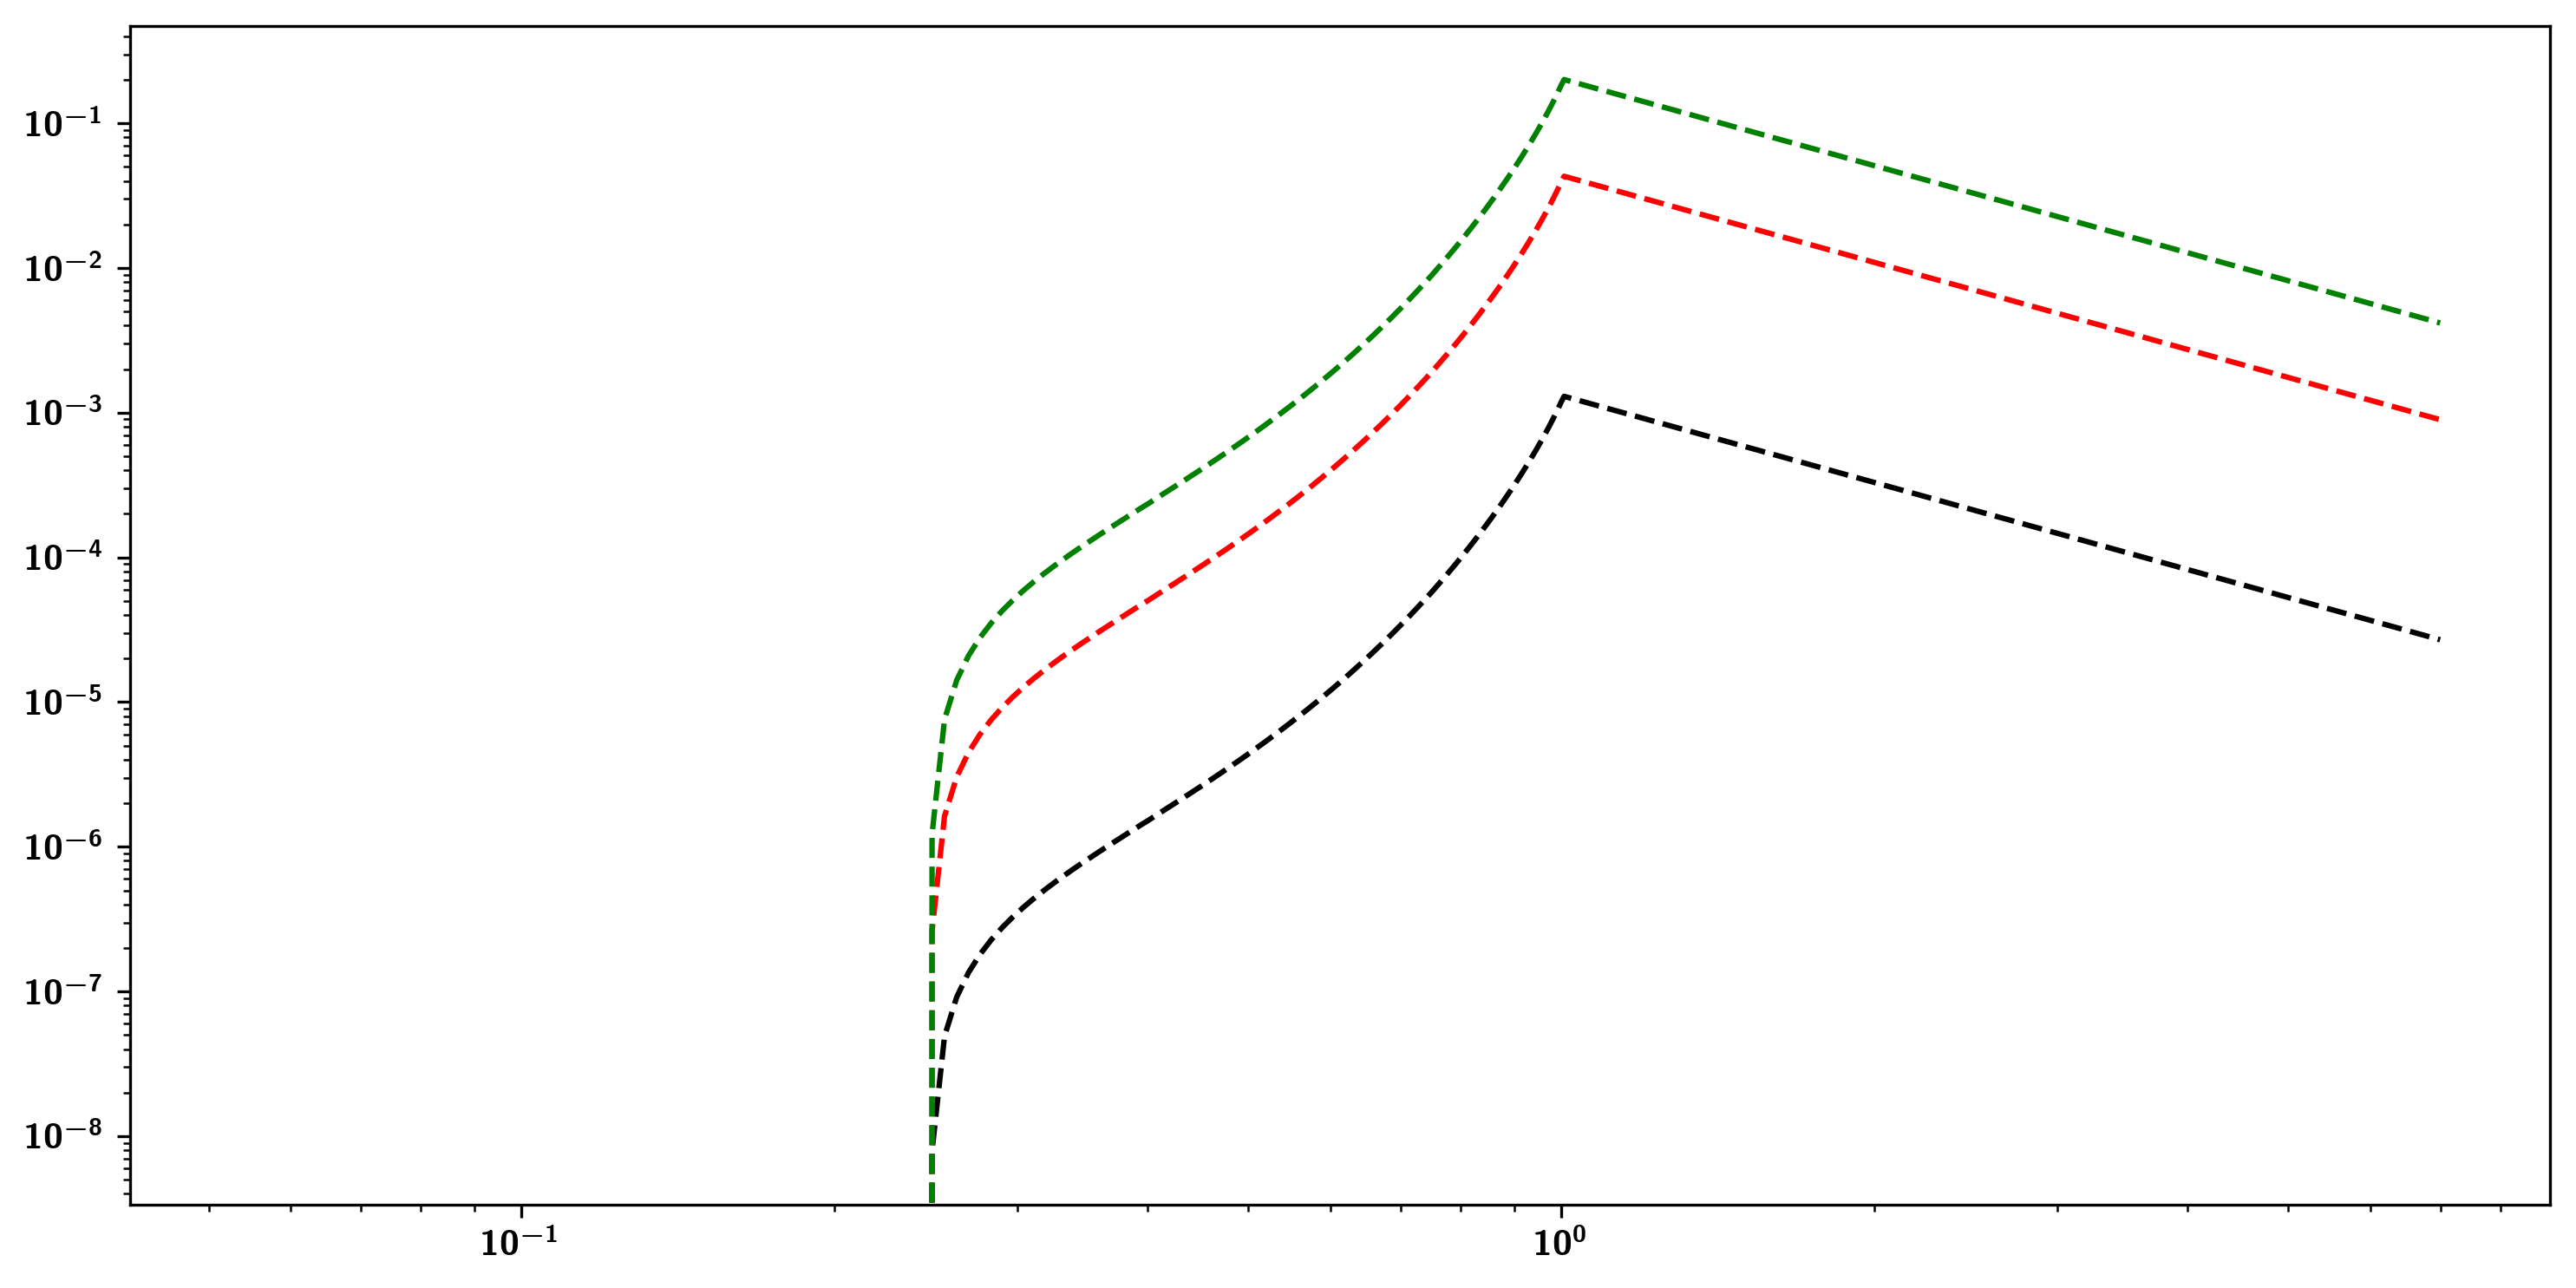

In [15]:
%matplotlib inline
plots, axes = plt.subplots(figsize=(12,6),dpi=300)
axes.plot(x1v,fr_fr[0,:],color='black',linestyle='dashed')
axes.plot(x1v,fr_fr[1,:],color='red',linestyle='dashed')
axes.plot(x1v,fr_fr[2,:],color='green',linestyle='dashed')
axes.set_xscale('log')
axes.set_yscale('log')

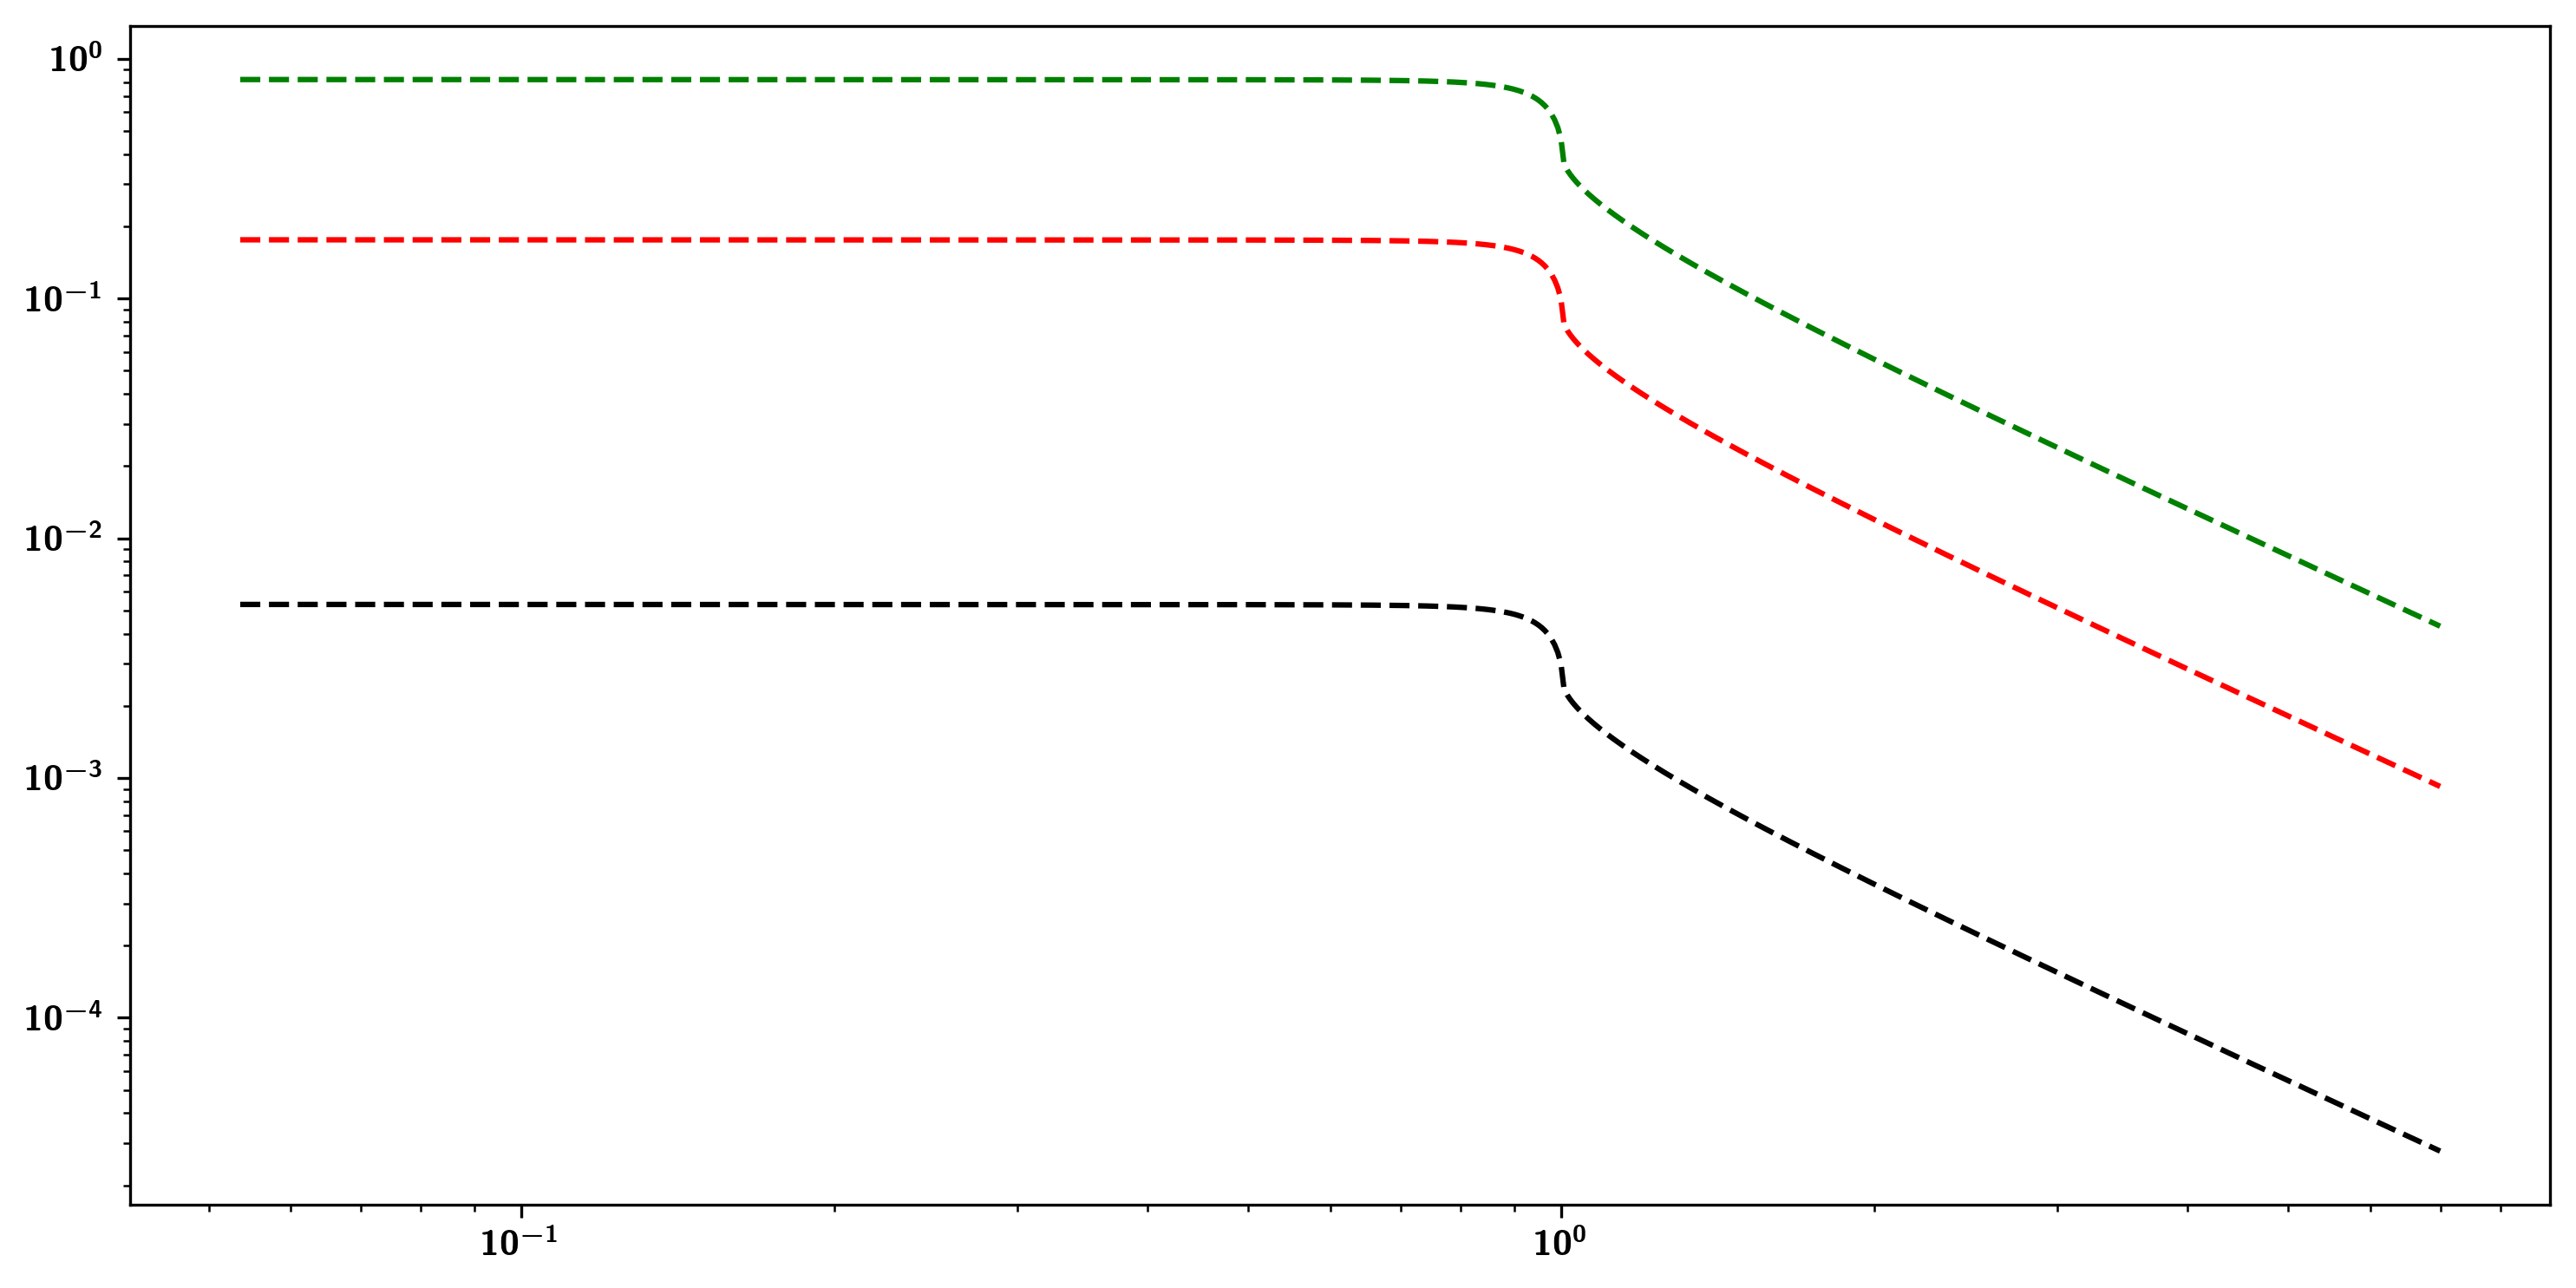

In [16]:
plots, axes = plt.subplots(figsize=(12,6),dpi=300)
axes.plot(x1v,er_fr[0,:],color='black',linestyle='dashed')
axes.plot(x1v,er_fr[1,:],color='red',linestyle='dashed')
axes.plot(x1v,er_fr[2,:],color='green',linestyle='dashed')
axes.set_xscale('log')
axes.set_yscale('log')

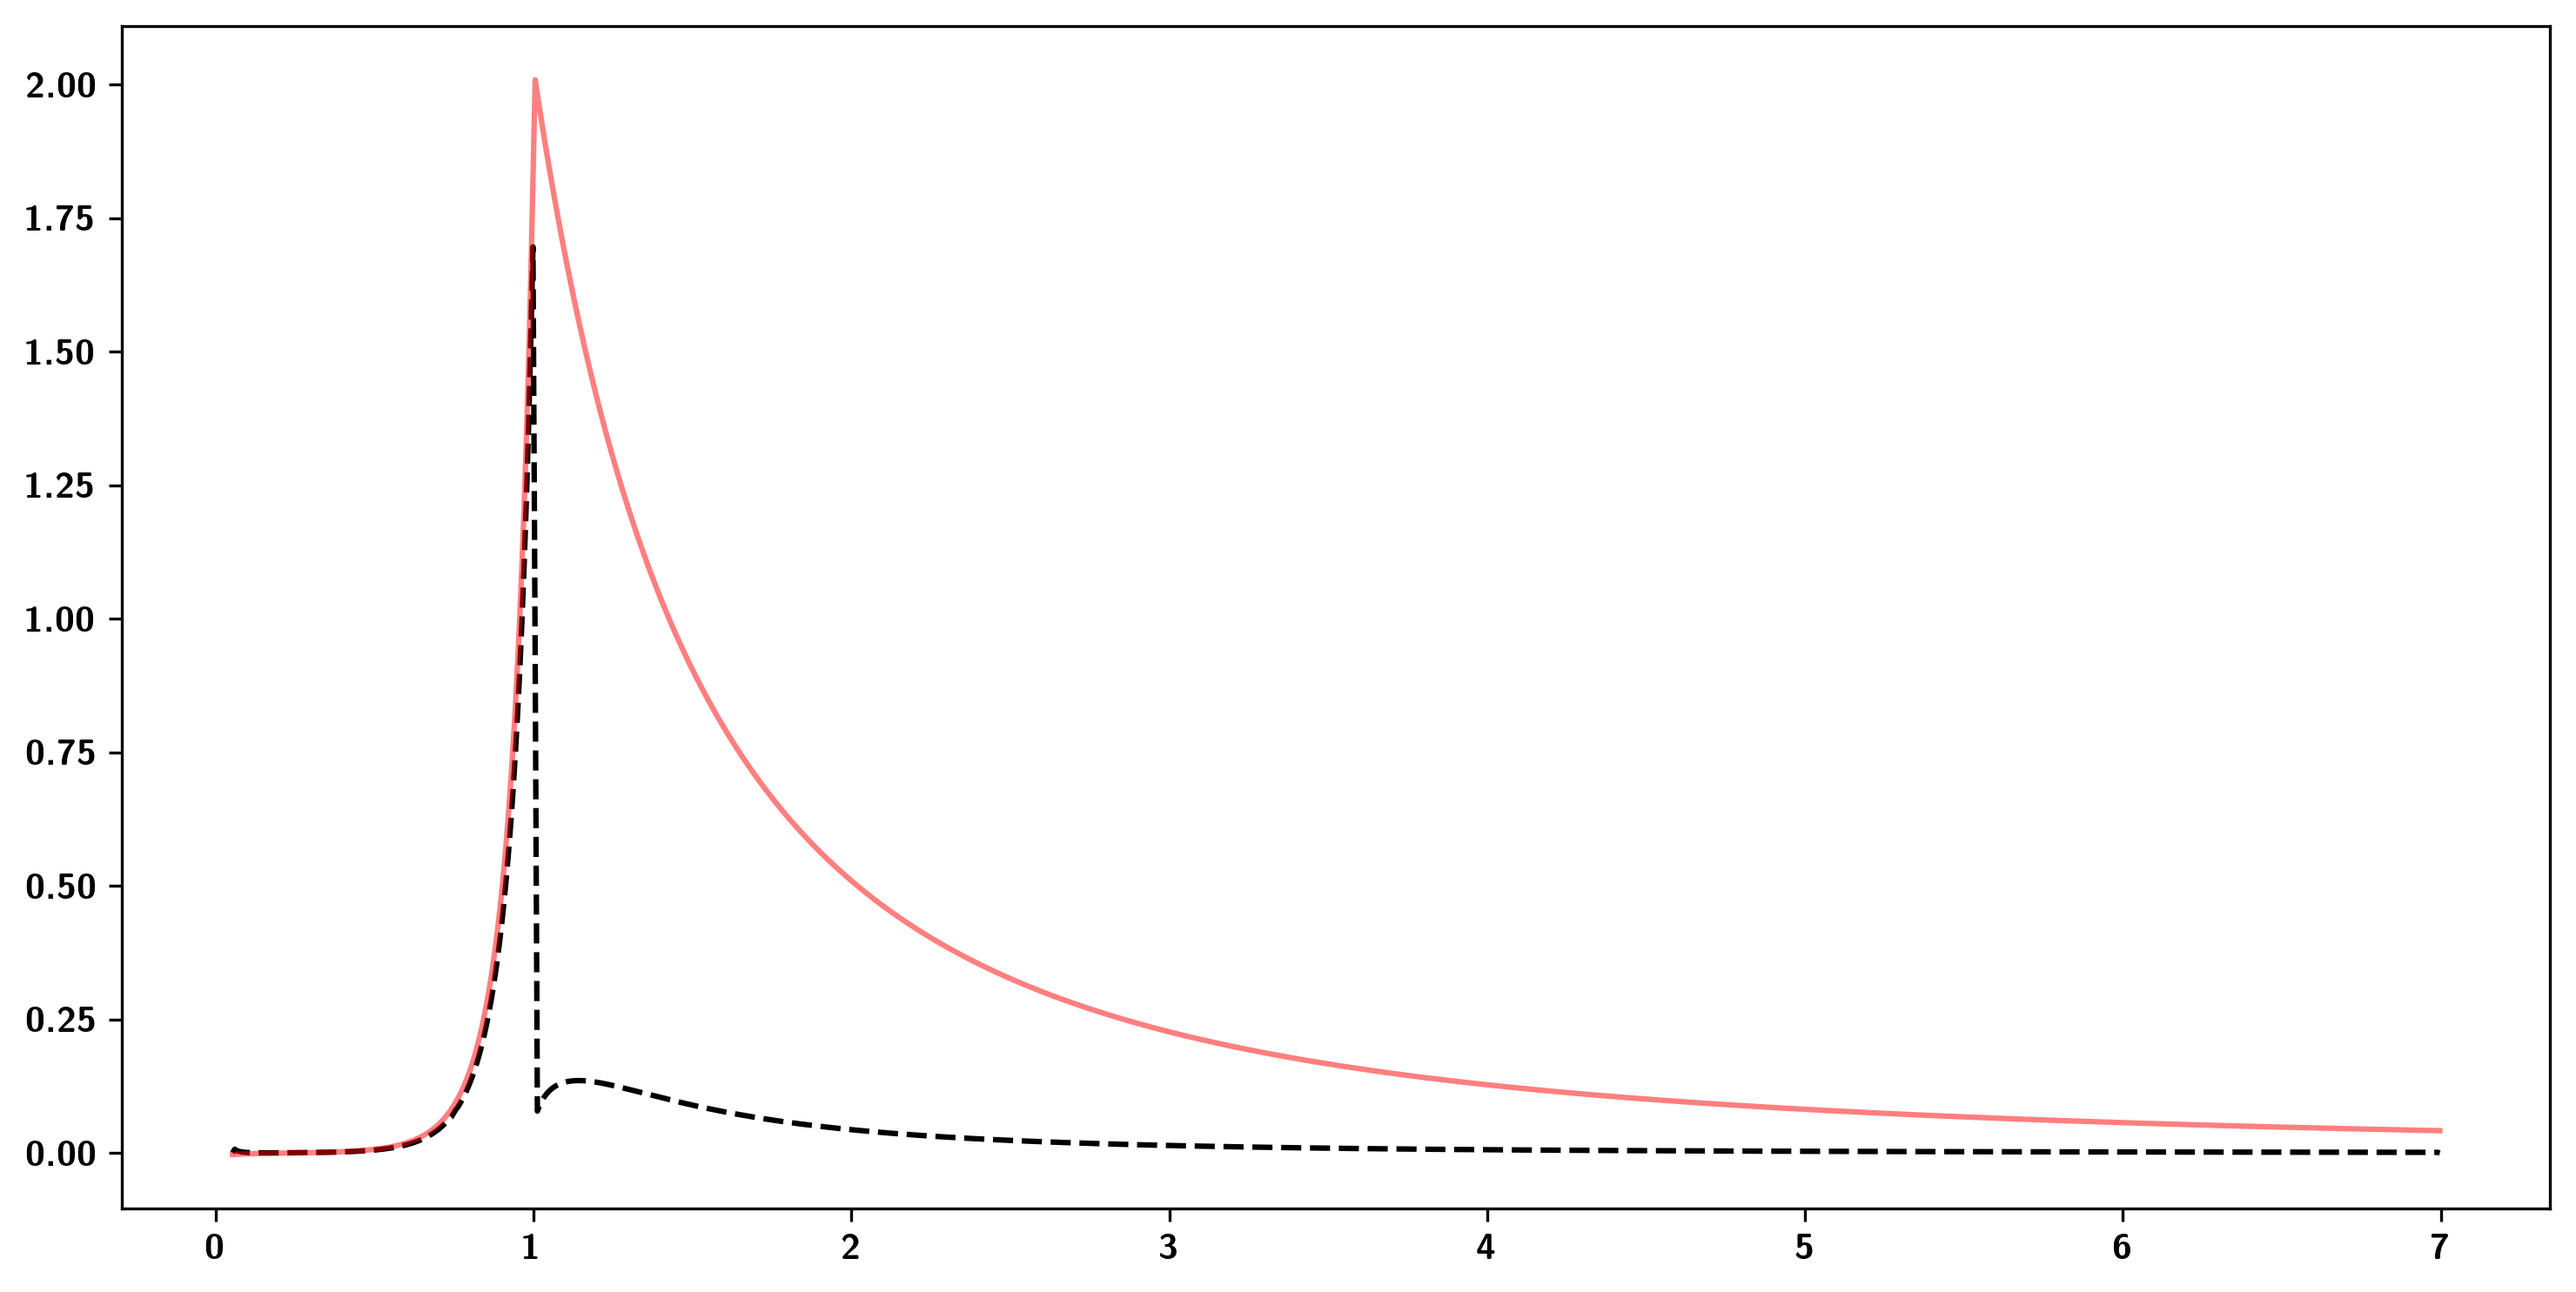

In [17]:
%matplotlib inline
plots, axes = plt.subplots(figsize=(12,6),dpi=300)
axes.plot(x1v,-dprdr[2,:],color='black',linestyle='dashed')
axes.plot(x1v,Crat*fr_fr[2,:],color='red',alpha=0.5)

In [18]:
sol=[sol_radius,sol_Er,sol_Fr,sol_Pr,nu_weight]
data=[x1v,er_profile,fr_profile,pr_profile,er_fr,fr_fr]

In [56]:
ylabel1='$E_r/a_rT_0^4, P_r/E_r$'
ylabel2='$F_r/ca_rT_0^4$'
filename='hom_sphere.pdf'
PlotProfile2(data,sol,filename,ylabel1,ylabel2,label1='$E_{r,0}$',label2='$P_r/E_r$')

/var/folders/2n/ftypqy6s65s2j7krblnn49cw0000gq/T/ipykernel_30757/1668594823.py:48: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.clf()


<Figure size 2700x3300 with 0 Axes>